# Plaing with Planar Flows
This notebook contains various experiments with Planar Flows introduced in Variational Inference with Normalizing Flows paper:  https://arxiv.org/abs/1505.05770

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%load_ext autoreload
%autoreload 2

tf.__version__

'1.8.0'

# Variational Inference with Normalizing Flows - Planar Flows 
Trying to reproduce one of Figure 3. from https://arxiv.org/abs/1505.05770

In [2]:
import utils


def w_initializer(shape, scale=1):
    w = 2 * scale * (np.random.rand(*shape) - 0.5)    
    return w.astype('float32')


class PlanarFlow():
    def __init__(self, dim, scale=1.0, bias_scale=1.0, w_scale=1.0, activation_fn=tf.nn.tanh):
        super().__init__()
        self.weight = tf.get_variable('weight', initializer=w_scale * (w_initializer([1, dim])))
        self.bias = tf.get_variable('bias', initializer=scale * w_initializer([1, 1]))
        self.scale = tf.get_variable('scale', initializer=bias_scale * (w_initializer([1, dim])))
        self.activation = activation_fn
        
    def linear(self, z):
        return tf.reduce_sum(z * self.weight, axis=-1, keepdims=True) + self.bias
        
    def _forward(self, z):
        logits = self.linear(z)
        return z + self.scale * self.activation(logits)

    def _log_det_jacobian(self, z):
        logits = self.linear(z)
        psi = (1 - self.activation(logits) ** 2) * self.weight
        det_grad = tf.abs(1 + tf.reduce_sum(psi * self.scale, axis=-1))
        return utils.safe_log(det_grad)

## Visualize randomly initialized planar flow density plot with Gaussian prior
This will correspond to Fig. 1 K=1 from the paper.

In [3]:
# this will create a grid of points in range x=[-1, 1] and y=[-1, 1]
vx = np.linspace(-1, 1, 100)
vy = np.linspace(-1, 1, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T
points.shape

(10000, 2)

In [4]:
tf.reset_default_graph()
np.random.seed(10290320)

z0 = tf.placeholder(tf.float32, shape=[None, 2], name='z0')
q0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[0.5, 0.5])

flow = PlanarFlow(2, scale=0.2, bias_scale=0.1, w_scale=20.0)
z1 = flow._forward(z0)

log_det_jacobian1 = flow._log_det_jacobian(z0)
q0_prob = tf.reduce_prod(q0.prob(z0), axis=-1)
q = utils.safe_log(q0_prob) - log_det_jacobian1


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    z1_np, log_probs_np = sess.run([z1, q], feed_dict={z0: points})
    rpoints = sess.run(q0.sample(500000))
    sampled_points = sess.run(z1, feed_dict={z0: rpoints})

In [5]:
sampled_points.max()

2.5700912

Compare sampled distribution with analitycal one

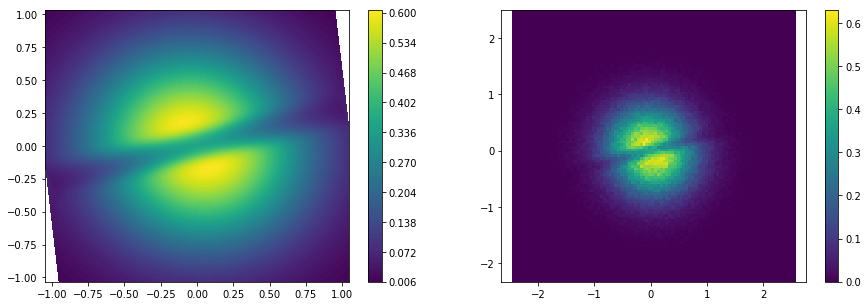

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.tricontourf(z1_np[:, 0], z1_np[:, 1], np.exp(log_probs_np), 100)
plt.colorbar()
plt.subplot(122)
plt.hist2d(sampled_points[:, 0], sampled_points[:, 1], 100, normed=True)
plt.axis('equal')
plt.colorbar()

# Visualize multiple transformations

In [7]:
tf.reset_default_graph()
np.random.seed(10290320)

z0 = tf.placeholder(tf.float32, shape=[None, 2], name='z0')
q0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[0.5, 0.5])


z = z0
log_det_jacobians = 0
for n in range(8):
    with tf.variable_scope(f'flow{n}'):
        flow = PlanarFlow(2, scale=0.2, bias_scale=0.1, w_scale=20.0)             
        log_det_jacobians = log_det_jacobians + flow._log_det_jacobian(z)
        z = flow._forward(z)

        
q0_prob = tf.reduce_prod(q0.prob(z0), axis=-1)
log_q0_prob = utils.safe_log(q0_prob)
q = log_q0_prob - log_det_jacobians


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    log_probs_np, z1_np = sess.run([q, z], feed_dict={z0: points})  
    rpoints = sess.run(q0.sample(500000))
    sampled_points = sess.run(z, feed_dict={z0: rpoints})

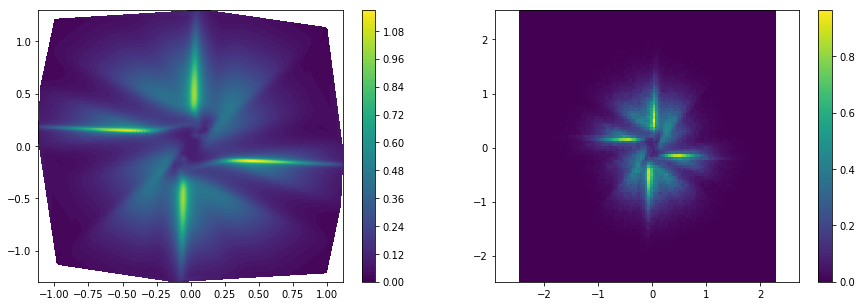

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.tricontourf(z1_np[:, 0], z1_np[:, 1], np.exp(log_probs_np), 100)
plt.colorbar()
plt.subplot(122)
plt.hist2d(sampled_points[:, 0], sampled_points[:, 1], 100, normed=True)
plt.axis('equal')
plt.colorbar()

## Reconstructing Figure 3 K=1

In [9]:
vx = np.linspace(-5, 5, 100)
vy = np.linspace(-5, 5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T

## Define potential model

In [10]:
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1

def potential_energy(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0) - 2.)/.4)**2 \
        - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))

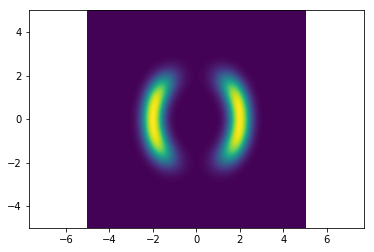

In [11]:
with tf.Session() as sess:
    probs = sess.run(potential_energy(tf.to_float(points)))

plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.axis('equal') 
plt.xlim([-5, 5])
_ = plt.ylim([-5, 5])

Define model and test initial density plot in 2D 

In [12]:
def build_planar_flow_model(q0, z0, K=4):
    """Simple implementation of planar flows"""    
    zk = z0
    log_det_jacobians = 0
    for n in range(K):
        with tf.variable_scope(f'flow{n}'):
            flow = PlanarFlow(2, scale=0.1, bias_scale=1.0, w_scale=1.0)             
            log_det_jacobians = log_det_jacobians + flow._log_det_jacobian(zk)
            zk = flow._forward(zk)

    q0_prob = tf.reduce_prod(q0.prob(z0), axis=-1)
    log_q0_prob = utils.safe_log(q0_prob)
    log_prob_k = log_q0_prob - log_det_jacobians
    return zk, log_prob_k

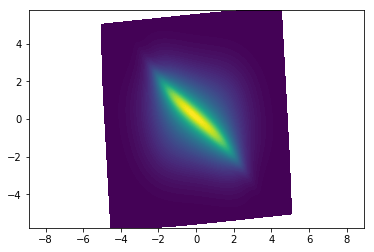

In [13]:
tf.reset_default_graph()
np.random.seed(10290710)

q0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.5, 1.5])
z0 = tf.placeholder(tf.float32, shape=[None, 2], name='z0')
zk, log_prob_k = build_planar_flow_model(q0, z0)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    log_prob_np, zk_np = sess.run([log_prob_k, zk], feed_dict={z0: points})
    
# Plot initial density
plt.tricontourf(zk_np[:, 0], zk_np[:, 1], np.exp(log_prob_np), 100)
_ = plt.axis('equal')    

## Define final model and loss function

In [14]:
tf.reset_default_graph()

q0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.5, 1.5])
z0 = q0.sample(128)
zk, log_prob_k = build_planar_flow_model(q0, z0, K=16)

# define loss, p(zk) = exp(- U(zk)) => - log(p(zk)) = U(zk)
loss = potential_energy(zk) + log_prob_k
loss = tf.reduce_mean(loss)

## Train model with maximum likelihood method

Unfortunatelly, this is extremely slow ...

  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.005 22.54812


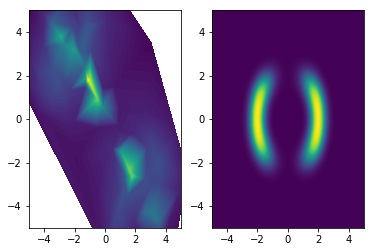

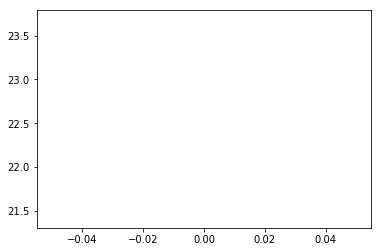

 10%|█         | 1000/10000 [00:26<04:01, 37.21it/s]

1000 0.0046759658 -1.7669977


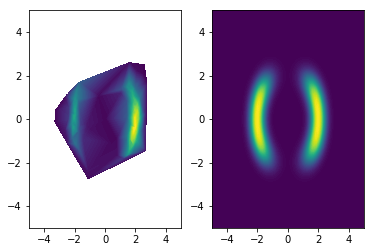

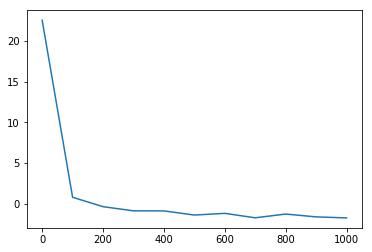

 20%|█▉        | 1998/10000 [00:52<03:30, 38.00it/s]

2000 0.0043729316 -1.7600406


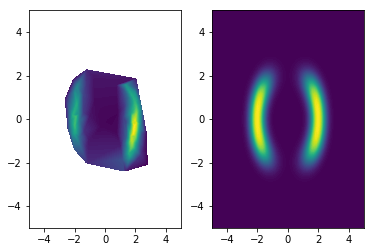

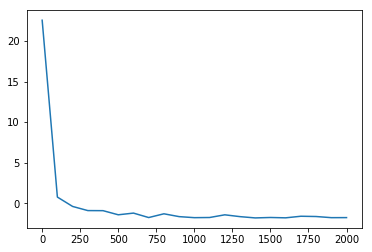

 30%|██▉       | 2999/10000 [01:18<03:04, 37.98it/s]

3000 0.004089535 -1.7767627


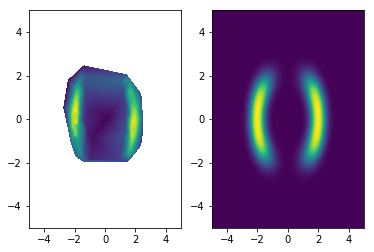

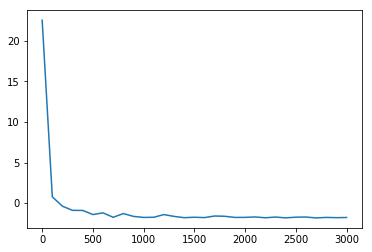

 40%|███▉      | 3998/10000 [01:44<02:37, 38.12it/s]

4000 0.0038245057 -1.8344669


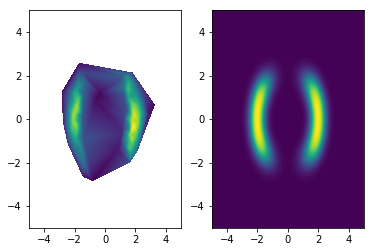

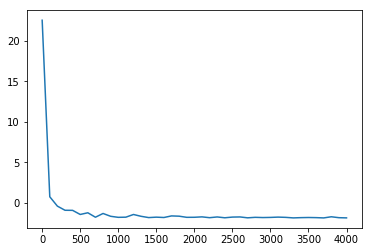

 50%|█████     | 5000/10000 [02:11<02:11, 38.13it/s]

5000 0.0035766514 -1.8341838


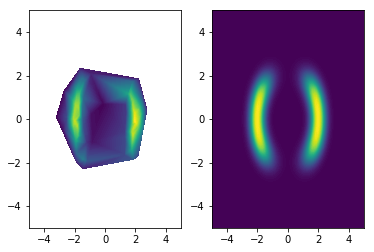

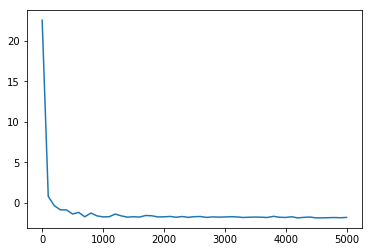

 60%|██████    | 6000/10000 [02:37<01:45, 38.09it/s]

6000 0.00334486 -1.8487743


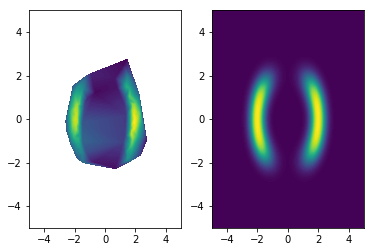

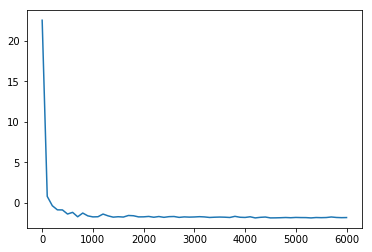

 70%|██████▉   | 6998/10000 [03:03<01:18, 38.14it/s]

7000 0.0031280902 -1.870252


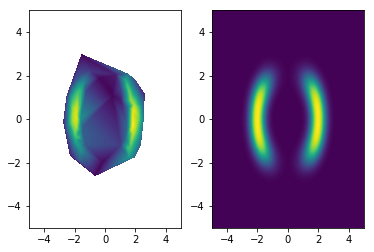

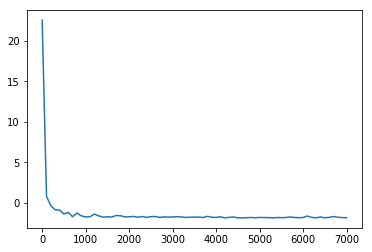

 80%|███████▉  | 7997/10000 [03:29<00:52, 38.16it/s]

8000 0.0029253685 -1.8952692


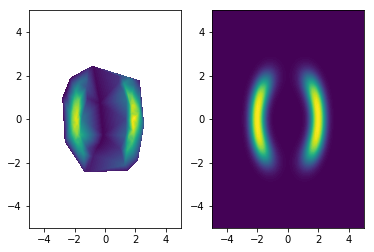

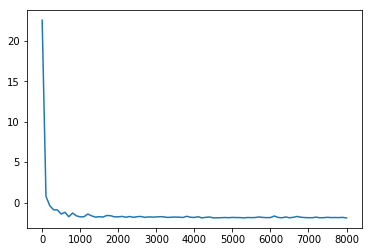

 90%|████████▉ | 8998/10000 [03:55<00:26, 38.22it/s]

9000 0.0027357845 -1.7889423


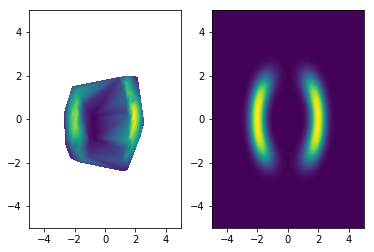

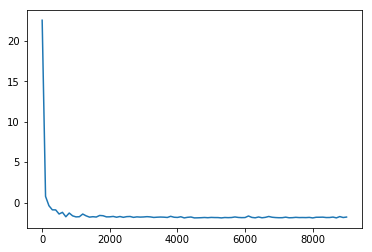

100%|██████████| 10000/10000 [04:21<00:00, 38.22it/s]


In [15]:
from collections import defaultdict
from tqdm import tqdm

global_step = tf.placeholder(dtype=tf.int32, shape=())

learning_rate = tf.train.exponential_decay(
    0.005, global_step, 150, 0.99
)

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NUM_STEPS = int(1e4)
hist = defaultdict(list)

for i in tqdm(range(NUM_STEPS)):
    _, lr_np, loss_np = sess.run([
        train_op, learning_rate, loss], 
        feed_dict={global_step: i}
    )
    if i % 100 == 0:
        hist['lr'].append(lr_np)
        hist['global_step'].append(i)
        hist['loss'].append(loss_np)
        
    if i % int(1000) == 0:
        print(i, lr_np, loss_np )
        log_probs_np, zk_np = sess.run([log_prob_k, zk])
        
        plt.subplot(121)
        plt.tricontourf(zk_np[:, 0], zk_np[:, 1], np.exp(log_probs_np), 100)        
        plt.xlim([-5,5])
        plt.ylim([-5,5])
        
        plt.subplot(122)
        plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)        
        plt.xlim([-5,5])
        plt.ylim([-5,5])
        plt.show()
        
        plt.plot(hist['global_step'], hist['loss'])
        plt.show()

Show samples from trained model:

In [ ]:
zk_list = [sess.run(zk) for i in range(1000)]
zk_samples = np.concatenate(zk_list)

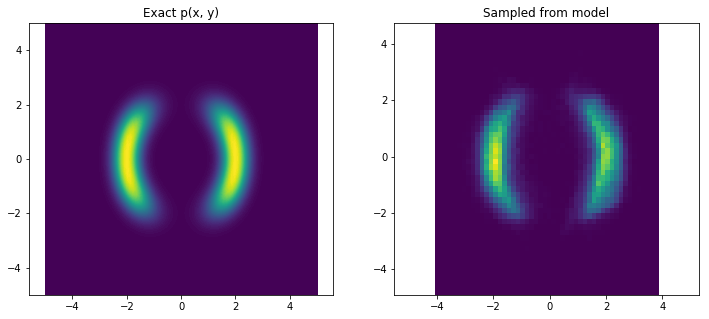

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Exact p(x, y)")
plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.axis('equal') 
plt.xlim([-5, 5])
_ = plt.ylim([-5, 5])
plt.subplot(122)
plt.title("Sampled from model")
_ = plt.hist2d(zk_samples[:, 0], zk_samples[:, 1], 50)
_ = plt.axis('equal')